# Machine Learning for Predicting Revenue from the Amazon E-Commerce Sales Data Analysis


### Predicting the Revenue in the next 3 months with ARIMA

#### I. Installing Statmodels and preparing the time series for forecasting
The chosen model for forecasting is ARIMA (AutoRegressive Integrated Moving Average)

In [ ]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


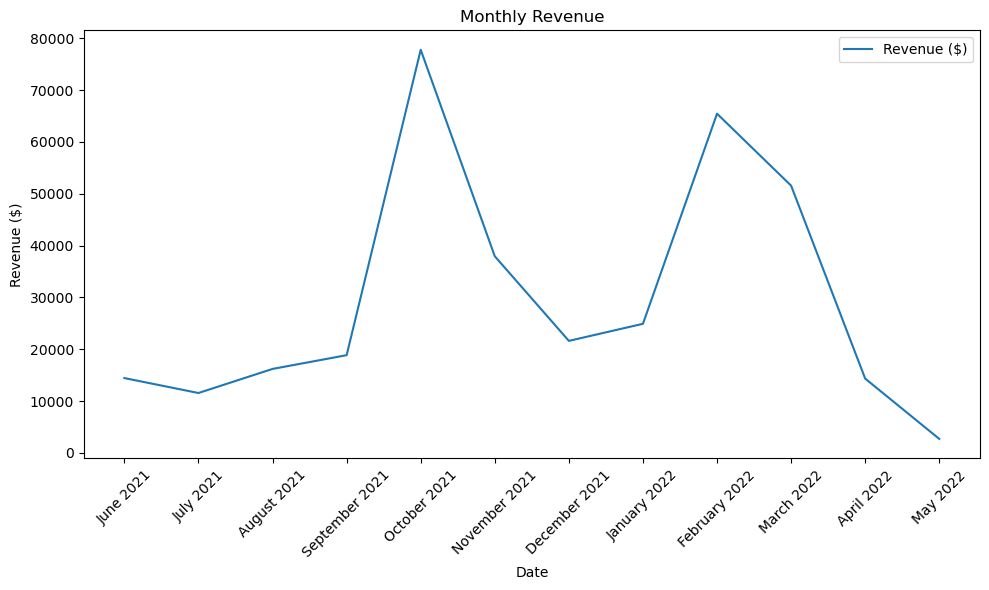

In [ ]:
# Ensure the month_year column is set as the index
monthly_sales_2021.set_index('month_year', inplace=True)

# Extract revenue column for forecasting
revenue_series = monthly_sales_2021['gross_amount($)']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(revenue_series, label='Revenue ($)')
plt.title('Monthly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### II. Augmented Dickey Fuller test (ADF) to test whether the time series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(revenue_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret results
if result[1] > 0.05:
    print("The p-value is greater than 0.05. The time series is not stationary. Differencing is required.")
else:
    print("The p-value is smaller than 0.05. The time series is stationary.")

ADF Statistic: -2.6728340145445806
p-value: 0.07885829101634217
The p-value is greater than 0.05. The time series is not stationary. Differencing is required.


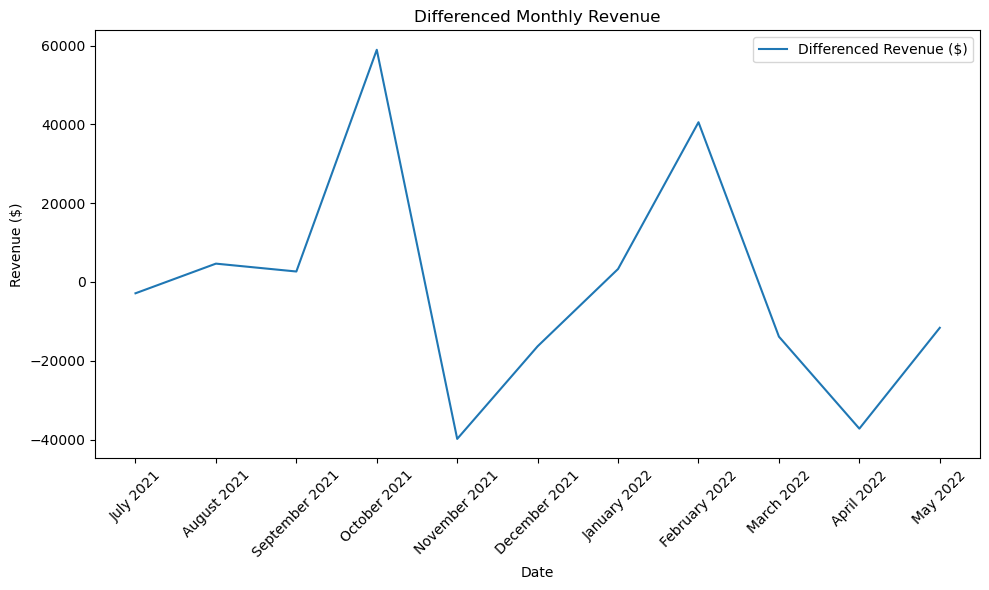

In [ ]:
# Apply first-order differencing
diff_revenue_series = revenue_series.diff().dropna()

# Plot differenced series
plt.figure(figsize=(10, 6))
plt.plot(diff_revenue_series, label='Differenced Revenue ($)')
plt.title('Differenced Monthly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### III. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine the parameters

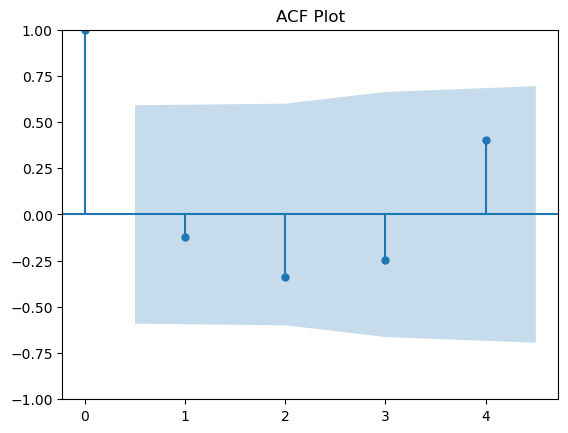

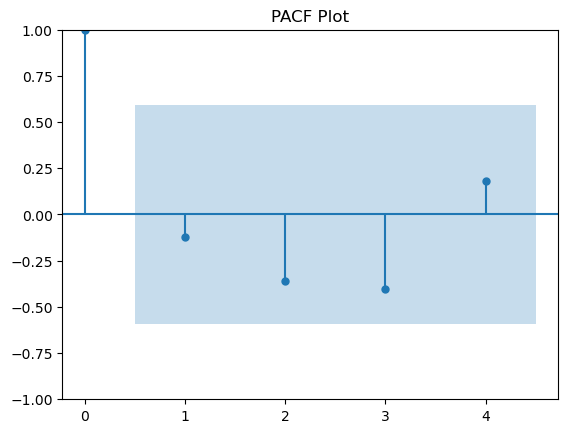

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate maximum allowed lags (50% of sample size)
max_lags = len(diff_revenue_series) // 2

# Use minimum between desired lags (10) and max allowed lags
n_lags = min(4, max_lags)

# Plot ACF and PACF for original or differenced series
plot_acf(diff_revenue_series, lags=n_lags)
plt.title('ACF Plot')
plt.show()

plot_pacf(diff_revenue_series, lags=n_lags)
plt.title('PACF Plot')
plt.show()

ACF Plot:
- There is a significant positive spike at **lag 1**, indicating that the series has short-term autocorrelation and suggests the presence of a moving average term.
- The autocorrelations drop significantly after lag 1, with values falling within the confidence interval at lags 2, 3, and beyond. This suggests that higher-order moving average terms (q>1q>1) are not needed.

PACF Plot:

- There is a significant positive spike at **lag** 1, indicating that the series has short-term partial autocorrelation and suggests the presence of an autoregressive term.
- The partial autocorrelations drop significantly after lag 1, with values falling within the confidence interval at lags 2, 3, and beyond. This suggests that higher-order autoregressive terms are not needed.

Differencing Order (d)
- The Augmented Dickey-Fuller (ADF) test had confirmed the time series need differencing.

Based on the analysis of the ACF and PACF plots, the suggested model is ARIMA(1,1,1).

#### IV. Running ARIMA(1, 1, 1)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(revenue_series, order=(1, 1, 1))
arima_results = arima_model.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:        gross_amount($)   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -127.162
Date:                Mon, 31 Mar 2025   AIC                            260.325
Time:                        23:55:45   BIC                            261.519
Sample:                    06-01-2021   HQIC                           259.572
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3995      0.714      0.559      0.576      -1.001       1.800
ma.L1         -1.0000      0.336     -2.977      0.003      -1.658      -0.342
sigma2      5.636e+08   5.96e-10   9.46e+17      0.0

c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

Parameter Estimates:

•	AR(1) Coefficient (ϕ1=0.3995): Not statistically significant (p-value=0.576), suggesting the autoregressive component does not meaningfully contribute to the model.

•	MA(1) Coefficient (θ1=−1.0000): Statistically significant (p-value=0.003), indicating strong reliance on past forecast errors for adjusting future predictions.

•	Residual Variance (σ^2=5.636×108): Extremely high, indicating large prediction errors, poor forecast accuracy or scaling issues in the data.

Model Diagnostics:

•	Ljung-Box Test (Q=0.01,p=0.94): Residuals are uncorrelated at lag 1.

•	Jarque-Bera Test (JB=2.12,p=0.35): Residuals are approximately normally distributed.

•	Heteroskedasticity Test (H=0.72,p=0.76): No significant variance instability.

Due to the AR(1) being statistically insignificant (suggesting redundancy), I have opted for the ARIMA(0, 1, 1) model.

#### V. Running ARIMA(0, 1, 1)

In [ ]:
arima_model_new = ARIMA(revenue_series, order=(0, 1, 1))
arima_results_new = arima_model_new.fit()
print(arima_results_new.summary())

                               SARIMAX Results                                
Dep. Variable:        gross_amount($)   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -127.871
Date:                Mon, 31 Mar 2025   AIC                            259.743
Time:                        23:55:45   BIC                            260.538
Sample:                    06-01-2021   HQIC                           259.241
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7123      0.360     -1.977      0.048      -1.418      -0.006
sigma2       5.71e+08   7.79e-11   7.33e+18      0.000    5.71e+08    5.71e+08
Ljung-Box (L1) (Q):                   0.38   Jarque-

c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\chauc\miniconda3\envs\jrm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

Parameter Estimates:

- MA(1) Coefficient (θ1 = −0.7123): Statistically significant (p-value=0.048), indicating the MA term contributes meaningfully.
- In SES terms, this corresponds to a smoothing parameter α = 1−θ = 1.7123, which is unusually large (typically 0<α<1).
- Residual Variance (σ^2 =5.71×10^8): Extremely high, suggesting large prediction errors or data scaling issues.

Model Diagnostics:

- Ljung-Box Test (Q=0.38,p=0.54): Residuals are uncorrelated at lag 1.
- Jarque-Bera Test (JB=0.92,p=0.63): Residuals are approximately normally distributed.
- Heteroskedasticity Test (H=0.80,p=0.84): No significant variance instability.
- The model is parsimonious (low AIC/BIC: 259.743/260.538) and aligns with SES principles.

Comparisons between 2 models:
- The ARIMA(0,1,1) model demonstrates superior performance in terms of model selection metrics. It has a lower Akaike Information Criterion (AIC = 259.743) and Bayesian Information Criterion (BIC = 260.538) compared to ARIMA(1,1,1) (AIC = 260.325, BIC = 261.519). While ARIMA(1,1,1) has a marginally better log likelihood (-127.162 vs. -127.871), the improvement is negligible and does not justify its higher AIC/BIC values.
- Both models include a significant MA(1) term (ARIMA(0,1,1): θ1=−0.7123, p=0.048; ARIMA(1,1,1): θ1=−1.0000, p=0.003). However, ARIMA(1,1,1) includes an AR(1) term (ϕ1=0.3995) that is statistically insignificant (p=0.576p=0.576). This redundancy suggests that the autoregressive component adds no meaningful explanatory power.
- Randomness: Both models pass the Ljung-Box test, indicating residuals are uncorrelated.
- Normality: ARIMA(0,1,1) has residuals closer to normality (JB=0.92, p=0.63) compared to ARIMA(1,1,1) (JB=2.12, p=0.35) 


Conclusion:

The ARIMA(0,1,1) model provides a baseline forecast but fails to capture critical dynamics in the daily revenue data, such as volatility and non-linear trends. While the MA(1) term is significant, the residuals’ non-normality and heteroskedasticity highlight the need for transformations or more sophisticated models. ARIMA(0,1,1) is still the better choice due to its lower AIC/BIC, simpler structure, and adherence to residual assumptions althought it may reflect a lack of trend or seasonality in the data. While both models suffer from high residual variance and covariance matrix instability, these issues stem from the small dataset (n=12) rather than model specification.


#### VI. Plotting Residuals

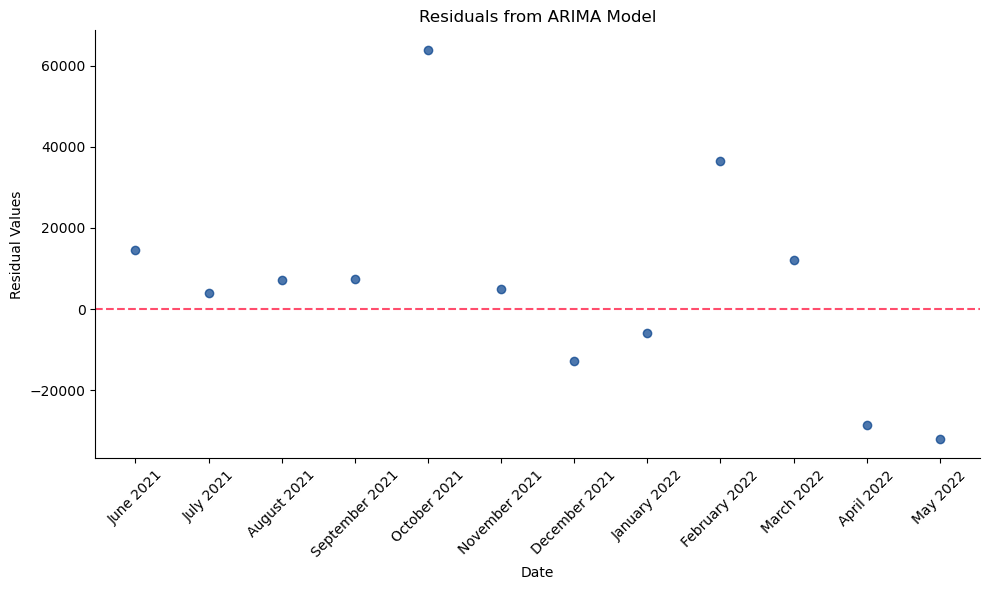


Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  14.104275   0.168288

Interpretation:
The p-value is greater than 0.05, indicating that residuals are independently distributed (no significant autocorrelation).


In [ ]:
# Plot residuals from ARIMA(0, 1, 1)
residuals = arima_results_new.resid

plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='none', color='#023e8a', alpha=0.7)
plt.axhline(y=0, color='#ff4d6d', linestyle='--')
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residual Values')
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Perform Ljung-Box test for residual randomness
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test Results:")
print(ljung_box_results)

# Print interpretation of results
lb_pvalue = ljung_box_results['lb_pvalue'].values[0]
print("\nInterpretation:")
if lb_pvalue > 0.05:
    print("The p-value is greater than 0.05, indicating that residuals are independently distributed (no significant autocorrelation).")
else:
    print("The p-value is less than 0.05, indicating that residuals may have significant autocorrelation.")

#### VII. Plotting the future revenue forecast

Forecasted revenue for the next 3 months:
2022-06-01    25540.665552
2022-07-01    25540.665552
2022-08-01    25540.665552
Freq: MS, Name: predicted_mean, dtype: float64


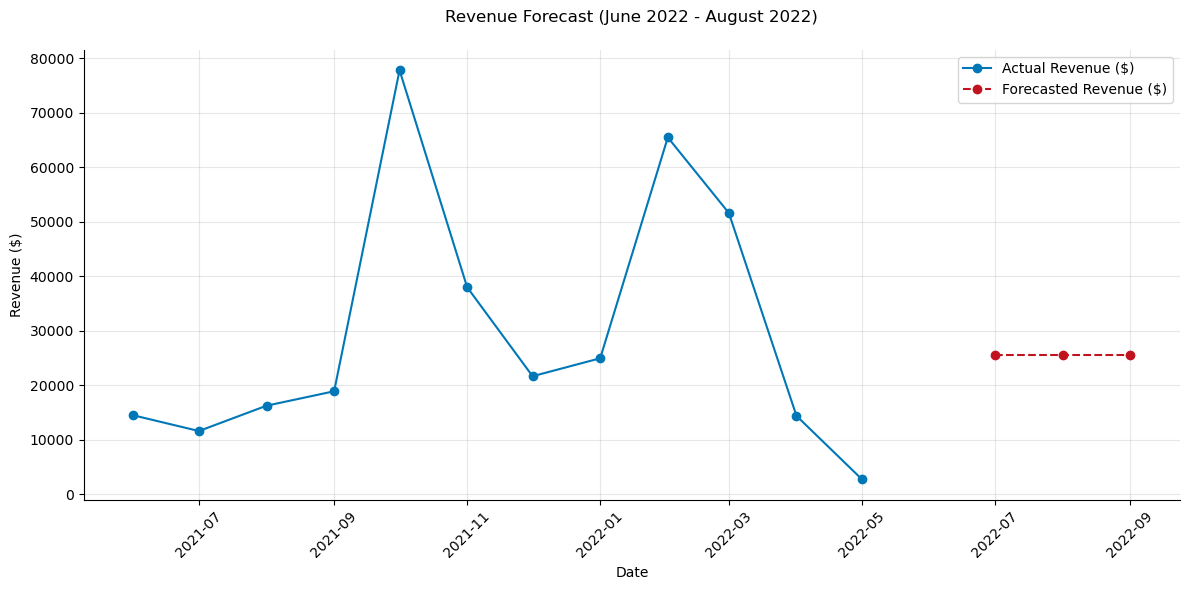

In [ ]:
# Forecast future revenue in the next 3 months due to limited data
forecast_steps = 3
forecast_arima_011 = arima_results_new.forecast(steps=forecast_steps)
print(f"Forecasted revenue for the next 3 months:\n{forecast_arima_011}")

# Create forecast index
last_date = pd.to_datetime('2022-05-11')  # Last date in the actual data
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, 
                             freq='MS')

# Plot forecasted values alongside actual data
plt.figure(figsize=(12, 6))
plt.plot(pd.date_range('2021-06-01', '2022-05-11', freq='MS'), 
         revenue_series.values, 
         marker='o',
         color='#0077b6',
         label='Actual Revenue ($)')
plt.plot(forecast_index, 
         forecast_arima_011.values, 
         linestyle='--', 
         marker='o',
         color='#c1121f',
         label='Forecasted Revenue ($)')

plt.title('Revenue Forecast (June 2022 - August 2022)', fontsize=12, pad=20)
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Key Observations:
- The ARIMA(0,1,1) model produces **constant forecasts** (red dashed line) because it functions as a random walk with drift, lacking autoregressive terms (p = 0) and relying solely on a single moving average term (q = 1) to adjust for past errors. This simplicity prevents it from capturing **trends, seasonality, or fluctuations** in the actual revenue data (blue line), which exhibits sharp peaks and troughs. The mismatch arises because ARIMA(0,1,1) extrapolates the last observed value without accounting for underlying dynamics like seasonality or non-linear trends.